# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [9]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [10]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = 1, output channels = 6, kernel size = 5
    # input image size = (32, 32), image output size = (28, 28)
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) # stride=1, padding=0
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2) #stride = kernel_size

    # input channel = 6, output channels = 16, kernel size = 5
    # input image size = (14, 14), output image size = (10, 10)
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

    # input dim = 5*5*16 ( H x W x C), output dim = 120
    self.fc1 = torch.nn.Linear(in_features=5*5*16, out_features=120)
    self.activation1 = torch.nn.ReLU()

    # input dim = 120, output dim = 84
    self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
    self.activation2 = torch.nn.ReLU()

    # input dim = 84, output dim = 10
    self.fc3 = torch.nn.Linear(in_features=84, out_features=10)
    # self.activation3 = torch.nn.ReLU()

  def forward(self, x):
    x = F.pad(x, (2, 2, 2, 2))
    # Max Pooling with kernel size = 2
    # output size = (14, 14)
    x = self.conv1(x)
    x = self.pool1(x)

    # Max Pooling with kernel size = 2
    # output size = (5, 5)
    x = self.conv2(x)
    x = self.pool2(x)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x =self.activation1(self.fc1(x))
    x = self.activation2(self.fc2(x))
    x = self.fc3(x)

    return x

### Define cost function

In [11]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [12]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [13]:
def test(net, data_loader, cost_function, device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [14]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [15]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
          device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
          learning_rate=0.01,
          weight_decay=0.000001,
          momentum=0.9,
          epochs=50,
          net = None):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU
  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # device = torch.device("cpu")
  net = LeNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  return net, test_loader, train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy

Lets train!

In [16]:
# main(**config,net=LeNet().to(config['device']), save_path='lenet.pth')
net, test_loader, train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy = main()

Before training:
	 Training loss 0.01806, Training accuracy 7.87
	 Validation loss 0.00906, Validation accuracy 7.88
	 Test loss 0.00922, Test accuracy 8.52
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00700, Training accuracy 69.50
	 Validation loss 0.00079, Validation accuracy 94.01
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00127, Training accuracy 94.83
	 Validation loss 0.00049, Validation accuracy 96.33
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00083, Training accuracy 96.79
	 Validation loss 0.00039, Validation accuracy 96.82
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00066, Training accuracy 97.30
	 Validation loss 0.00035, Validation accuracy 97.19
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00052, Training accuracy 97.94
	 Validation loss 0.00035, Validation accuracy 97.30
------------------

Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?



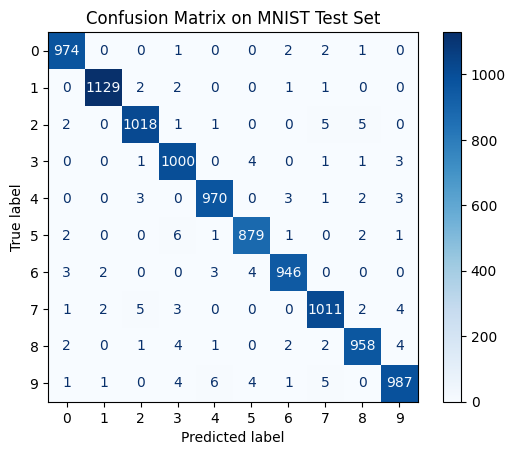

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_confusion_matrix(net, data_loader, device='cpu'):
    net.eval()  # Switch to eval mode
    all_targets = []
    all_predicted = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            _, predicted = outputs.max(1)

            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    return confusion_matrix(all_targets, all_predicted)


cm = get_confusion_matrix(net, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on MNIST Test Set")
plt.show()


**Answer**: We can see the hardest digits to classify are 5, 6 and 8. Due to their shapes and multiple aways of writing them, it can be difficult for the model to correctly classify them by analysing a few features.

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

## Experiments

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.


In [44]:
from torchvision.models import resnet18
from torchvision.transforms import v2

In [45]:
def get_data_cifar10(batch_size, test_batch_size=256, augmentation=False):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  if augmentation:
    transform.append(v2.RandomResizedCrop(size=32, antialias=True))   # Randomly crops the image to (32, 32) 
    transform.append(v2.RandomHorizontalFlip(p=0.5))                  # Randomly flips the image horizontally
  transform.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [46]:
class LeNetCIFAR10(torch.nn.Module):
  def __init__(self, dropout = False):
    super(LeNetCIFAR10, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # input 28x28 with 3 channels (RGB)
    # self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    # self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

    # input dim = 5*5*16 ( H x W x C), output dim = 120
    self.fc1 = torch.nn.Linear(in_features=5*5*16, out_features=120)
    # self.activation1 = torch.nn.ReLU()

    # input dim = 120, output dim = 84
    self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
    # self.activation2 = torch.nn.ReLU()

    # input dim = 84, output dim = 10
    self.fc3 = torch.nn.Linear(in_features=84, out_features=10)

    # dropout
    self.dropout = dropout
    if self.dropout:
      self.dropout1 = torch.nn.Dropout(p=0.5)
      self.dropout2 = torch.nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = F.relu(x)
    if self.dropout:
      x = self.dropout1(x)

    x = self.fc2(x)
    x = F.relu(x)
    if self.dropout:
      x = self.dropout2(x)

    x = self.fc3(x)

    return x

In [54]:
# early stopping
def main_early_stop(batch_size=128,
                    device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
                    learning_rate=0.01,
                    weight_decay=0.000001,
                    momentum=0.9,
                    epochs=50,
                    early_stopping=False,
                    data_augmentation=False,
                    dropout=False,
                    cifar10 = False,
                    resnet18 = False,
                    K = 3):

    if cifar10:
        net = LeNetCIFAR10(dropout).to(device)
        train_loader, val_loader, test_loader = get_data_cifar10(batch_size, augmentation=data_augmentation)
    elif resnet18:
        # use ResNet18 model
        net = resnet18().to(device)
        train_loader, val_loader, test_loader = get_data(batch_size)
    else:
        net = LeNet().to(device)
        train_loader, val_loader, test_loader = get_data(batch_size)        

    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    cost_function = get_cost_function()

    print('Before training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    if early_stopping:
        # early stopping parameters
        last_val_loss = torch.inf
        last_val_acc = 0
        es = 0
        for e in range(epochs):
            train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function, device)
            val_loss, val_accuracy = test(net, val_loader, cost_function, device)

            print('Epoch: {:d}'.format(e+1))
            print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
            print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
            # Early stopping
            if val_loss >= last_val_loss or abs(val_accuracy - last_val_acc) <= 0.01:
                print('Validation loss increased from {:.2f} to {:.2f}'.format(last_val_loss, val_loss))
                es += 1
            else:
                es = 0
            last_val_loss = val_loss
            last_val_acc = val_accuracy
            if es >= K:
                print('Early stopping at epoch {:d}'.format(e+1))
                break
            print('-----------------------------------------------------')            

    else:
        for e in range(epochs):
            train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
            val_loss, val_accuracy = test(net, val_loader, cost_function)
            print('Epoch: {:d}'.format(e+1))
            print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
            print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
            print('-----------------------------------------------------')

    print('After training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    return net, test_loader

In [51]:
# early stopping
def main_early_stop(batch_size=128,
                    device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
                    learning_rate=0.01,
                    weight_decay=0.000001,
                    momentum=0.9,
                    epochs=50,
                    early_stopping=False,
                    data_augmentation=False,
                    cifar10 = False,
                    resnet18 = False,
                    K = 3):

    if cifar10:
        net = LeNetCIFAR10().to(device)
        train_loader, val_loader, test_loader = get_data_cifar10(batch_size, augmentation=data_augmentation)
    elif resnet18:
        # use ResNet18 model
        net = resnet18().to(device)
        train_loader, val_loader, test_loader = get_data(batch_size)
    else:
        net = LeNet().to(device)
        train_loader, val_loader, test_loader = get_data(batch_size)        

    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    cost_function = get_cost_function()

    print('Before training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    if early_stopping:
        # early stopping parameters
        last_val_loss = torch.inf
        last_val_acc = 0
        es = 0
        for e in range(epochs):
            train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function, device)
            val_loss, val_accuracy = test(net, val_loader, cost_function, device)

            print('Epoch: {:d}'.format(e+1))
            print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
            print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
            
            # Early stopping
            if val_loss < last_val_loss - 1e-4:
                es = 0
                last_val_loss = val_loss
                print('Validation loss increased from {:.2f} to {:.2f}'.format(last_val_loss, val_loss))
            else:
                es += 1
            # last_val_loss = val_loss
            # last_val_acc = val_accuracy
            if es >= K:
                print('Early stopping at epoch {:d}'.format(e+1))
                break
            print('-----------------------------------------------------')            

    else:
        for e in range(epochs):
            train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
            val_loss, val_accuracy = test(net, val_loader, cost_function)
            print('Epoch: {:d}'.format(e+1))
            print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
            print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
            print('-----------------------------------------------------')

    print('After training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    return net, test_loader

In [52]:
# early stopping
_, _ = main_early_stop(early_stopping=True)

Before training:
	 Training loss 0.01803, Training accuracy 15.01
	 Validation loss 0.00905, Validation accuracy 15.33
	 Test loss 0.00920, Test accuracy 16.21
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00667, Training accuracy 71.35
	 Validation loss 0.00086, Validation accuracy 93.25
Validation loss increased from 0.00 to 0.00
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00115, Training accuracy 95.54
	 Validation loss 0.00045, Validation accuracy 96.70
Validation loss increased from 0.00 to 0.00
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00072, Training accuracy 97.09
	 Validation loss 0.00045, Validation accuracy 96.49
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00057, Training accuracy 97.65
	 Validation loss 0.00035, Validation accuracy 97.32
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00044, Trai

In [53]:
# cifar10, just early stopping 
_, _ = main_early_stop(early_stopping=True, cifar10=True)

Before training:
	 Training loss 0.01808, Training accuracy 10.07
	 Validation loss 0.00904, Validation accuracy 9.92
	 Test loss 0.00922, Test accuracy 10.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01757, Training accuracy 15.80
	 Validation loss 0.00800, Validation accuracy 24.26
Validation loss increased from 0.01 to 0.01
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01484, Training accuracy 29.77
	 Validation loss 0.00680, Validation accuracy 36.44
Validation loss increased from 0.01 to 0.01
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01274, Training accuracy 40.09
	 Validation loss 0.00614, Validation accuracy 42.36
Validation loss increased from 0.01 to 0.01
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01173, Training accuracy 45.47
	 Validation loss 0.00591, Validation accuracy 45.30
Validation loss increased from 0.01 to 0.01
-----

In [55]:
# cifar10, early stopping + data augmentation + dropout
_, _ = main_early_stop(early_stopping=True, data_augmentation=True, dropout=True, cifar10=True)

Before training:
	 Training loss 0.01807, Training accuracy 9.96
	 Validation loss 0.00903, Validation accuracy 10.04
	 Test loss 0.00922, Test accuracy 10.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01801, Training accuracy 11.71
	 Validation loss 0.00888, Validation accuracy 16.56
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01709, Training accuracy 17.76
	 Validation loss 0.00815, Validation accuracy 21.90
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01616, Training accuracy 21.18
	 Validation loss 0.00778, Validation accuracy 23.60
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01572, Training accuracy 23.78
	 Validation loss 0.00766, Validation accuracy 26.36
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01539, Training accuracy 25.83
	 Validation loss 0.00745, Validation accuracy 28.92
----------------

In [56]:
# cifar10, resnet18, early stopping 
_, _ = main_early_stop(early_stopping=True, cifar10=True, resnet18=True)

Before training:
	 Training loss 0.01806, Training accuracy 9.90
	 Validation loss 0.00903, Validation accuracy 10.16
	 Test loss 0.00922, Test accuracy 10.03
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01777, Training accuracy 14.63
	 Validation loss 0.00837, Validation accuracy 22.26
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01514, Training accuracy 29.21
	 Validation loss 0.00674, Validation accuracy 37.35
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01309, Training accuracy 38.59
	 Validation loss 0.00623, Validation accuracy 41.98
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01210, Training accuracy 43.51
	 Validation loss 0.00614, Validation accuracy 42.06
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01160, Training accuracy 46.22
	 Validation loss 0.00574, Validation accuracy 46.89
----------------